##ThinkDSP

This notebook contains solutions to exercises in Chapter 6: Discrete Cosine Transform

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import thinkstats2

import numpy as np
import scipy.fftpack

import warnings
warnings.filterwarnings('ignore')

import dct

%matplotlib inline

**Exercise:** In this chapter I claim that `analyze1` takes time proportional
to $n^3$ and `analyze2` takes time proportional to $n^2$.  To
see if that's true, run them on a range of input sizes and time
them.  In IPython, you can use the magic command `%timeit`.

If you plot run time versus input size on a log-log scale, you
should get a straight line with slope 3 for  `analyze1` and
slope 2 for `analyze2`.  You also might want to test `dct_iv`
and `scipy.fftpack.dct`.

I'll start with a noise signal and an array of power-of-two sizes

In [2]:
signal = thinkdsp.UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

In [3]:
ns = 2 ** np.arange(6, 14)
ns

array([   64,   128,   256,   512,  1024,  2048,  4096,  8192, 16384])

The following function takes an array of results from a timing experiment, plots the results, and fits a straight line.

In [4]:
def plot_bests(bests):    
    thinkplot.plot(ns, bests)
    thinkplot.config(xscale='log', yscale='log', legend=False)
    
    x = np.log(ns)
    y = np.log(bests)
    t = scipy.stats.linregress(x,y)
    slope = t[0]

    return slope

Here are the results for `analyze1`.

In [5]:
results = []
for N in ns:
    print(N)
    ts = (0.5 + np.arange(N)) / N
    freqs = (0.5 + np.arange(N)) / 2
    ys = noise.ys[:N]
    result = %timeit -r1 -o dct.analyze1(ys, freqs, ts)
    results.append(result)

bests = [result.best for result in results]
plot_bests(bests)

64
873 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
128
2.09 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
256
5.88 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
25.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
1024
88.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
443 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
2.09 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8192


KeyboardInterrupt: 

The estimated slope is close to 2, not 3, as expected.  One possibility is that the performance of `np.linalg.solve` is nearly quadratic in this range of array sizes.

The line is curved, which suggests that we have not reached the array size where the runtime shows cubic growth.  With larger array sizes, the estimated slope increases, so maybe it eventually converges on 3.

Here are the results for `analyze2`:

In [ ]:
results = []
for N in ns:
    ts = (0.5 + np.arange(N)) / N
    freqs = (0.5 + np.arange(N)) / 2
    ys = noise.ys[:N]
    result = %timeit -r1 -o dct.analyze2(ys, freqs, ts)
    results.append(result)

bests2 = [result.best for result in results]
plot_bests(bests2)

The results for `analyze2` fall in a straight line with the estimated slope close to 2, as expected.

Here are the results for the `scipy.fftpack.dct`

In [ ]:
results = []
for N in ns:
    ys = noise.ys[:N]
    result = %timeit -o scipy.fftpack.dct(ys, type=3)
    results.append(result)

bests3 = [result.best for result in results]
plot_bests(bests3)

This implementation of dct is even faster.  The line is curved, which means either we haven't seen the asymptotic behavior yet, or the asymptotic behavior is not a simple exponent of $n$.  In fact, as we'll see soon, the run time is proportional to $n \log n$.

The following figure shows all three curves on the same axes.

In [ ]:
thinkplot.preplot(3)
thinkplot.plot(ns, bests, label='analyze1')
thinkplot.plot(ns, bests2, label='analyze2')
thinkplot.plot(ns, bests3, label='fftpack.dct')
thinkplot.config(xscale='log', yscale='log', legend=True, loc='upper left')

**Exercise:** One of the major applications of the DCT is compression for both sound and images. In its simplest form, DCT-based compression works like this:

1. Break a long signal into segments.
2. Compute the DCT of each segment.
3. Identify frequency components with amplitudes so low they are inaudible, and remove them. Store only the frequencies and amplitudes that remain.
4. To play back the signal, load the frequencies and amplitudes for each segment and apply the inverse DCT.

Implement a version of this algorithm and apply it to a recording of music or speech. How many components can you eliminate before the difference is perceptible?

`thinkdsp` provides a class, `Dct` that is similar to a `Spectrum`, but which uses DCT instead of FFT.

As an example, I'll use a recording of a saxophone:

In [9]:
wave = thinkdsp.read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()

Here's a short segment:

In [10]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

And here's the DCT of that segment:

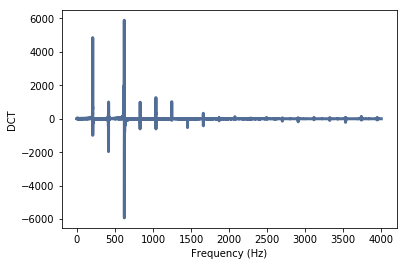

In [11]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
thinkplot.config(xlabel='Frequency (Hz)', ylabel='DCT')

There are only a few harmonics with substantial amplitude, and many entries near zero.

The following function takes a DCT and sets elements below `thresh` to 0.

In [12]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

If we apply it to the segment, we can eliminate more than 90% of the elements:

20457	22050	92.77551020408163


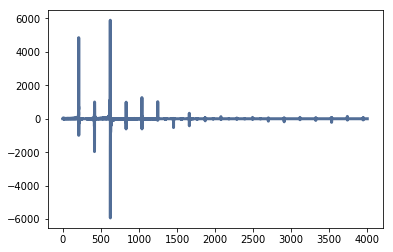

In [13]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=10)
seg_dct.plot(high=4000)

And the result sounds the same (at least to me):

In [14]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

To compress a longer segment, we can make a DCT spectrogram.  The following function is similar to `wave.make_spectrogram` except that it uses the DCT.

In [18]:
def make_dct_spectrogram(wave, seg_length):
    """Computes the DCT spectrogram of the wave.

    seg_length: number of samples in each segment

    returns: Spectrogram
    """
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length / 2

    # map from time to Spectrum
    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(int(i), int(j))
        segment.window(window)

        # the nominal time for this segment is the midpoint
        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return thinkdsp.Spectrogram(spec_map, seg_length)

Now we can make a DCT spectrogram and apply `compress` to each segment:

In [28]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=1)

1024	1024	100.0
1022	1024	99.8046875
1022	1024	99.8046875
1024	1024	100.0
1024	1024	100.0
1022	1024	99.8046875
1023	1024	99.90234375
1022	1024	99.8046875
1023	1024	99.90234375
1016	1024	99.21875
1016	1024	99.21875
1018	1024	99.4140625
1021	1024	99.70703125
1019	1024	99.51171875
1019	1024	99.51171875
1019	1024	99.51171875
1019	1024	99.51171875
1022	1024	99.8046875
1019	1024	99.51171875
1019	1024	99.51171875
1020	1024	99.609375
1020	1024	99.609375
1022	1024	99.8046875
1020	1024	99.609375
1022	1024	99.8046875
1013	1024	98.92578125
979	1024	95.60546875
1018	1024	99.4140625
1015	1024	99.12109375
1013	1024	98.92578125
1009	1024	98.53515625
993	1024	96.97265625
965	1024	94.23828125
970	1024	94.7265625
977	1024	95.41015625
972	1024	94.921875
978	1024	95.5078125
980	1024	95.703125
980	1024	95.703125
978	1024	95.5078125
981	1024	95.80078125
982	1024	95.8984375
978	1024	95.5078125
979	1024	95.60546875
976	1024	95.3125
977	1024	95.41015625
978	1024	95.5078125
971	1024	94.82421875
972	1024	94.92187

938	1024	91.6015625
938	1024	91.6015625
937	1024	91.50390625
937	1024	91.50390625
932	1024	91.015625
932	1024	91.015625
925	1024	90.33203125
930	1024	90.8203125
898	1024	87.6953125
928	1024	90.625
928	1024	90.625
922	1024	90.0390625
913	1024	89.16015625
923	1024	90.13671875
934	1024	91.2109375
938	1024	91.6015625
920	1024	89.84375
932	1024	91.015625
923	1024	90.13671875
936	1024	91.40625
929	1024	90.72265625
941	1024	91.89453125
939	1024	91.69921875
943	1024	92.08984375
945	1024	92.28515625
939	1024	91.69921875
933	1024	91.11328125
945	1024	92.28515625
942	1024	91.9921875
935	1024	91.30859375
947	1024	92.48046875
932	1024	91.015625
937	1024	91.50390625
937	1024	91.50390625
937	1024	91.50390625
943	1024	92.08984375
931	1024	90.91796875
936	1024	91.40625
941	1024	91.89453125
924	1024	90.234375
946	1024	92.3828125
941	1024	91.89453125
947	1024	92.48046875
943	1024	92.08984375
951	1024	92.87109375
945	1024	92.28515625
947	1024	92.48046875
947	1024	92.48046875
947	1024	92.48046875
955	1024	

977	1024	95.41015625
967	1024	94.43359375
980	1024	95.703125
973	1024	95.01953125
978	1024	95.5078125
970	1024	94.7265625
979	1024	95.60546875
980	1024	95.703125
979	1024	95.60546875
982	1024	95.8984375
981	1024	95.80078125
983	1024	95.99609375
989	1024	96.58203125
983	1024	95.99609375
987	1024	96.38671875
986	1024	96.2890625
987	1024	96.38671875
986	1024	96.2890625
981	1024	95.80078125
979	1024	95.60546875
987	1024	96.38671875
986	1024	96.2890625
986	1024	96.2890625
988	1024	96.484375
981	1024	95.80078125
989	1024	96.58203125
988	1024	96.484375
985	1024	96.19140625
990	1024	96.6796875
990	1024	96.6796875
989	1024	96.58203125
991	1024	96.77734375
992	1024	96.875
990	1024	96.6796875
993	1024	96.97265625
991	1024	96.77734375
993	1024	96.97265625
995	1024	97.16796875
996	1024	97.265625
994	1024	97.0703125
994	1024	97.0703125
996	1024	97.265625
995	1024	97.16796875
994	1024	97.0703125
994	1024	97.0703125
994	1024	97.0703125
997	1024	97.36328125
998	1024	97.4609375
994	1024	97.0703125
998	1

In most segments, the compression is 75-80%.

To hear what it sounds like, we can convert the spectrogram back to a wave and play it.

In [29]:
wave2 = spectro.make_wave()
wave2.make_audio()

And here's the original again for comparison.

In [21]:
wave.make_audio()